## ICM development
[Growth-factor-mediated coupling between lineage size and cell fate choice underlies robustness of mammalian development](https://elifesciences.org/articles/56079)

### Imports

In [178]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("Distributions")
Pkg.add("GLMakie")
Pkg.add("CSV")
Pkg.add("DataFrames")

# Enabling packages
using CellBasedModels
using Random
using Distributions
using GLMakie
using CSV
using DataFrames

Makie.inline!(true)

   Resolving package versions...

  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving 

package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`

true

### Code

#### Defining the Agent

In [179]:
model = ABM(3,

    #Inherit model mechanics
    baseModelInit = [CBMModels.softSpheres3D],

    #Global parameters
    model = Dict(
        #Chemical constants
        :α=>Float64, 
        :K=>Float64, 
        :nn=>Float64, 
        :mm=>Float64,
        #Physical constants
        :fRange=>Float64, 
        :mi=>Float64, 
        :ri=>Float64, 
        :k0=>Float64,
        #Division constants
        :fAdh=>Float64, 
        :τDiv=>Float64, 
        :σDiv=>Float64, 
        :c0=>Float64, 
        :σc=>Float64, 
        :nCirc=>Float64, 
        :σNCirc=>Float64,
        :fMin=>Float64, 
        :fMax=>Float64, 
        :fPrE=>Float64, 
        :fEPI=>Float64, 
        :τCirc=>Float64, 
        :στCirc=>Float64, 
        :rESC=>Float64,
        :nOn=>Float64, 
        :cMax=>Float64
    ),
    #Local float parameters
    agent = Dict(
        :c=>Float64,
        :tDivision=>Float64, #Variable storing the time of division of the cell
        :ci=>Float64, #Chemical activity of the neighbors
        :ni=>Float64,  #Number of neighbors
        :tOff=>Bool,    #indicate if the circuit for that cell is on or off (0,1)
        :cellFate=>Int64 #Identity of the cell (1 DP, 2 EPI, 3 PRE)
    ),
    #Chemical dynamics
    agentODE = quote

        ni = 0
        ci = 0
        @loopOverNeighbors it2 begin
            dij = CBMMetrics.euclidean(x,x[it2],y,y[it2],z,z[it2])
            rij = r+r[it2]
            if dij < fRange*rij
                ni += 1
                ci += c[it2]
            end
        end

        if tOff == false && N > nOn #Activate circuit
            dt( c ) = α*(1+c^nn)^mm/((1+c^nn)^mm+(1+(ci/ni)/K)^(2*mm)) - c
        end

    end,
    #Interaction computation
    agentRule=quote
        #Circuit deactivation and commitment
        if c < fPrE*cMax && tOff == false && N > nOn
            cellFate = 3
        elseif c > fEPI*cMax && tOff == false && N > nOn
            cellFate = 2
        end

        if c < fMin*cMax && tOff == false && N > nOn
            tOff = true
        elseif c > fMax*cMax && tOff == false && N > nOn
            tOff = true
        end

        #Growth
        if t > tDivision
            #Choose random direction in unit sphere
            xₐ = CBMDistributions.normal(0,1); yₐ = CBMDistributions.normal(0,1); zₐ = CBMDistributions.normal(0,1)
            Tₐ = sqrt(xₐ^2+yₐ^2+zₐ^2)
            xₐ /= Tₐ;yₐ /= Tₐ;zₐ /= Tₐ    

            #Chose a random distribution of the material
            dist = CBMDistributions.uniform(1-σc,1+σc)

            rsep = r/2
            rnew = r/(2. ^(1. /3))
            @addAgent( #Add new agent
                x = x+rsep*xₐ,
                y = y+rsep*yₐ,
                z = z+rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(dist),
                tDivision = t + CBMDistributions.uniform(τDiv*(1-σDiv),τDiv*(1+σDiv))
            )
            @addAgent( #Add new agent
                x = x-rsep*xₐ,
                y = y-rsep*yₐ,
                z = z-rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(2-dist),
                tDivision = t + CBMDistributions.uniform(τDiv*(1-σDiv),τDiv*(1+σDiv))
            )
            @removeAgent() # Remove agent that divided
            
        end
    end,

    agentAlg=CBMIntegrators.Heun()
);

#### Community construction and initialisation

##### Parameters

In [180]:
parameters = Dict([
    :α => 10,
    :K => .9,
    :nn => 2,
    :mm => 2,
    :fRange => 1.2,
    :mi => 10E-6,
    :ri => 5,
    :b => 10E-6,
    :k0 => 10E-4,
    :fAdh => 1.5,
    :μ => 2,
    :τDiv => 10,
    :σDiv => .5,
    :c0 => 3,
    :σc => 0.01,
    :nCirc => 20,
    :σNCirc => .1,
    :fMin => .05,
    :fMax => .95,
    :fPrE => .2,
    :fEPI => .8,
    :τCirc => 45.,
    :στCirc => .02,
    :rESC => 2,
    :f0 => [1 1 1;1 1 1;1 1 1]
]);

##### Initialise the community

In [181]:
function initializeEmbryo(parameters;dt)

    com = Community(
                model,
                N=1,
                dt=dt,
                )

    #Global parameters
    for (par,val) in pairs(parameters)
        com[par] = val
    end

    com.nOn = rand(Uniform(parameters[:nCirc]-parameters[:σNCirc],parameters[:nCirc]+parameters[:σNCirc]))
    com.cMax = parameters[:α]/(1+1/(2*parameters[:K])^(2*parameters[:mm]))

    #########Local parameters and variables###########
    com.f0 = parameters[:k0].*parameters[:f0]# / parameters[:fAdh]
    #Initialise locals
    com.m = parameters[:mi]
    com.r = parameters[:ri]
    com.cellFate = 1 #Start neutral fate
    com.tOff = false #Start with the tOff deactivated
    #Initialise variables
    com.x = 0.
    com.y = 0.
    com.z = 0.
    com.vx = 0.
    com.vy = 0.
    com.vz = 0.
    com.c = com.c0
    com.tDivision = 1#rand(Uniform(com.τDiv-com.σDiv,com.τDiv+com.σDiv))

    return com

end;

In [182]:
com = initializeEmbryo(parameters,dt=0.001);

#### Creating a custom evolve step

In [183]:
function customEvolve!(com,steps,saveEach)
    loadToPlatform!(com,preallocateAgents = 100)
    for i in 1:steps
        agentStepDE!(com)
        agentStepRule!(com)
        update!(com)
        computeNeighbors!(com)
        if i % saveEach == 0
            saveRAM!(com)
        end
        #Stop by time
        if all(com.N .> 60)
            break
        end
        #println(com.c[1:com.N])
    end
    bringFromPlatform!(com)
end;

In [184]:
dt = 0.001
steps = round(Int64,50/dt)
saveEach = round(Int64,.5/dt)

com = initializeEmbryo(parameters,dt=dt);
customEvolve!(com,steps,saveEach)

#### Visualization of results

In [185]:
function getFates(com)
    d = getParameter(com,[:t,:cellFate])

    dict = Dict()
    dict["t"] = [i[1] for i in d[:t]]
    dict["N"] = [length(i) for i in d[:cellFate]]
    for (fateNumber, fate) in zip([1,2,3],["DP","EPI","PRE"])
        dict[fate] = [sum(i.==fateNumber) for i in d[:cellFate]] 
    end

    return dict
end;

In [186]:
colorMap = Dict("DP"=>Makie.wong_colors()[1],"EPI"=>Makie.wong_colors()[2],"PRE"=>Makie.wong_colors()[3])
colorMapNum = Dict(1=>Makie.wong_colors()[1],2=>Makie.wong_colors()[2],3=>Makie.wong_colors()[3]);

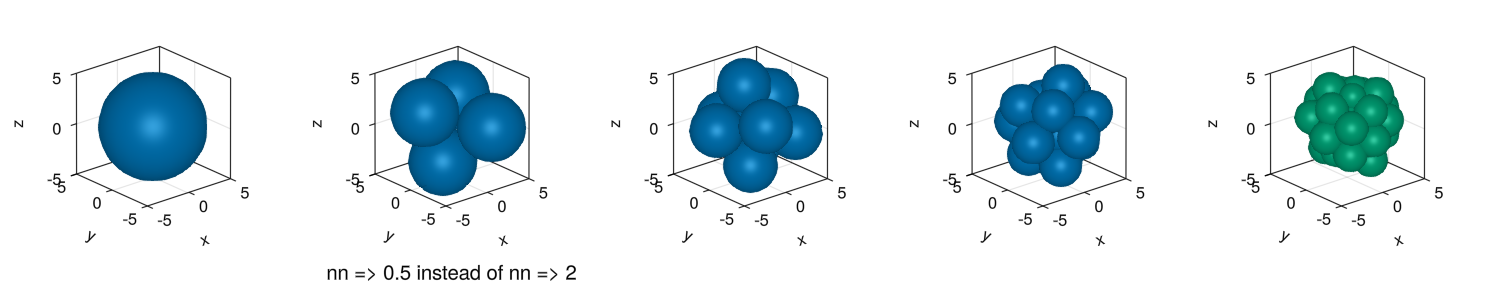

In [187]:
fig = Figure(resolution=(1500,300))

d = getParameter(com,[:x,:y,:z,:r,:cellFate])
for (i,pos) in enumerate([1:round(Int64,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],aspect = :data)
    color = [colorMapNum[i] for i in d[:cellFate][pos]]
    meshscatter!(ax,d[:x][pos],d[:y][pos],d[:z][pos],markersize=d[:r][pos],color=color)
    xlims!(ax,-5,5)
    ylims!(ax,-5,5)
    zlims!(ax,-5,5)
end

Label(fig[2, 1:3], "nn => 0.5 instead of nn => 2", fontsize = 20, halign = :center)

display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/testing/icm_development_testing_16.png", fig)